<a href="https://colab.research.google.com/github/jonatanbarkan/ACEDeep/blob/master/ADCEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1485]:
import numpy as np
from scipy.spatial.transform import Rotation
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
import tqdm
import pandas as pd
from collections import defaultdict
from time import sleep
from sklearn.cross_decomposition import CCA

sns.set_style("whitegrid")


In [1486]:
plt.rcParams['figure.dpi'] = 100
# plt.rcParams['figure.figsize']

In [1487]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1488]:
path_to_save = '/content/drive/My Drive/DeepACE/torus_rational/'

In [1489]:
add_non_linearity = True
add_non_linearity_invertible = False

In [1490]:
# hidden_size = 32
# num_hidden_layers = 3
# max_epochs = 30
# lr = 0.01
# act = None
# act = nn.ReLU
# batch_size = 32 * 4

In [1491]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)


cpu


### Create Samples

In [1492]:
d = 3
num_samples = 10000

In [1493]:
mu = [0]*d
cov = np.eye(d)

In [1494]:
kind = 'hex'
# kind = 'scatter'

In [1495]:
def get_normalization_params(dat, axis=0):
  return dat.mean(axis=axis), dat.std(axis=axis)

In [1496]:
def normalize(dat, mu, std):
  dat -= mu
  dat /= std
  return dat

In [1497]:
def white_noise(shape):
  # handles 2d shape only
  n_sump, degree = shape
  return np.random.multivariate_normal([0]*degree,  np.eye(degree), n_sump)

In [1498]:
def get_max_corr(var1, var2):
  cor = np.corrcoef(var1, var2, False)
  mask = np.ones(cor.shape, dtype=bool)
  np.fill_diagonal(mask, 0)
  return np.abs(cor[mask]).max()

In [1499]:
def corrfunc(var1, var2, **kws):
    r = get_max_corr(var1, var2)
    # print(r)
    if np.abs(r) > 0.3:
      ax = plt.gca()
      ax.annotate(f"|r| = {r:.2f}", xy=(.4, 0.97), xycoords=ax.transAxes)

In [1500]:
def compare_variables(y_vars, x_vars, name='', name_init=''):
  y_dict = {f'${var[0]}_{j} ({var[1][:, j].mean():.1f}, {var[1][:, j].std():.1f})$':var[1][:, j] for var in y_vars for j in range(var[1].shape[-1])}
  x_dict = {f'${var[0]}_{j} ({var[1][:, j].mean():.1f}, {var[1][:, j].std():.1f})$':var[1][:, j] for var in x_vars for j in range(var[1].shape[-1])}
  
  g = sns.PairGrid(
    data=pd.DataFrame({**y_dict, **x_dict}),
    y_vars=list(y_dict.keys()),
    x_vars=list(x_dict.keys())
    )
  
  g.map(sns.scatterplot)
  g.map(corrfunc)
  name = name.replace('_', ' ')
  g.fig.suptitle(f'Correlations\n{name}', y=1.08)
  plt.tight_layout()
  if name:
    name.replace(' ', '_')
    plt.savefig(path_to_save + name_init + f'{name}.png', bbox_inches='tight')
  return g

In [1501]:
# bz = compare_variables([('X^{prior}', X_prior)], [('Y^{prior}', Y_prior)])

In [1502]:
Z = np.random.multivariate_normal(mu, cov, num_samples)

In [1503]:
X_prior = Z + np.array([.9, .6, .2]) * white_noise(Z.shape)
Y_prior = Z + np.array([.1, .1, .3]) * white_noise(Z.shape)

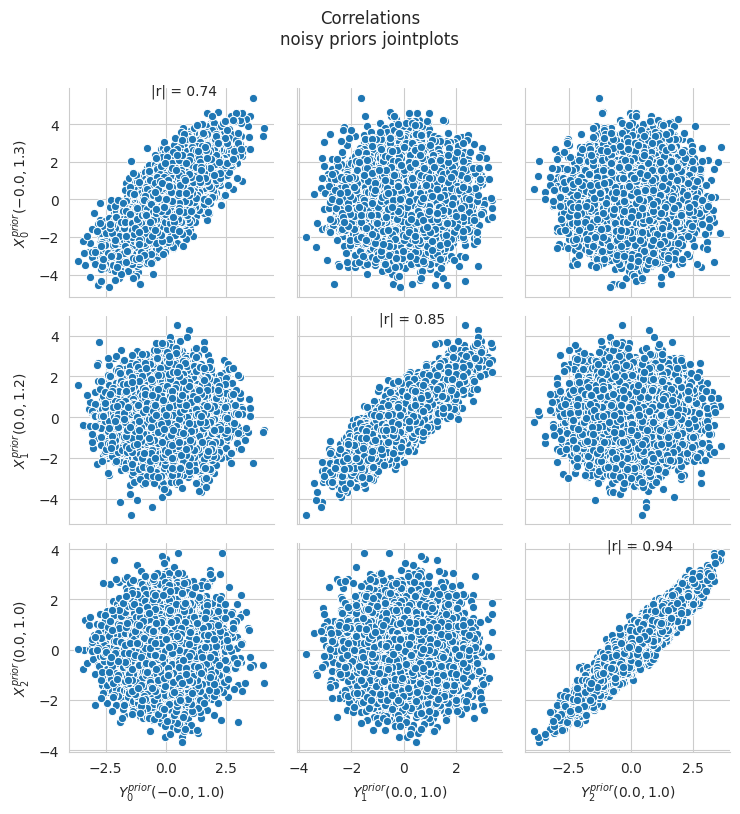

In [1504]:
compare_variables([('X^{prior}', X_prior)], [('Y^{prior}', Y_prior)], name='noisy_priors_jointplots', name_init='01')

In [1505]:

# torus prametrization
R = 5
# r = 2
def torus(vecs):
  a, b, c = vecs.T
  x1 = (R + a*np.cos(c))*np.cos(b)
  x2 = (R + a*np.cos(c))*np.sin(b)
  x3 = r*np.sin(c)
  return np.vstack((x1, x2, x3)).T


In [1506]:
eps = 0.1
def rational(vecs):
  a, b, c = vecs.T
  x1 = a / (np.abs(b) + eps)
  x2 = c + 200
  x3 = a*c
  return np.vstack((x1, x2, x3)).T


In [1507]:
def polynom(vecs):
  a, b, c = vecs.T
  x1 = a * b
  x2 = b * b * c - 2 * a
  x3 = a + 3*c*a
  return np.vstack((x1, x2, x3)).T

In [1508]:
def swap(vecs):
  a, b, c = vecs.T
  return np.vstack((c, a, b)).T

In [1509]:
non_linearity_1 = lambda a: a
non_linearity_2 = lambda a: a


In [1510]:
if add_non_linearity:
  if add_non_linearity_invertible:
    non_linearity_1 = lambda a: np.exp(a)
    non_linearity_2 = lambda a: np.arctan(np.pi * a)
  else:
    non_linearity_1 = torus
    non_linearity_2 = rational

In [1511]:
X_non_linear = non_linearity_1(X_prior)
X_non_linear = X_non_linear + 0.1 * white_noise(X_non_linear.shape)
Y_non_linear = non_linearity_2(Y_prior)
Y_non_linear = Y_non_linear + 0.1 * white_noise(Y_non_linear.shape)

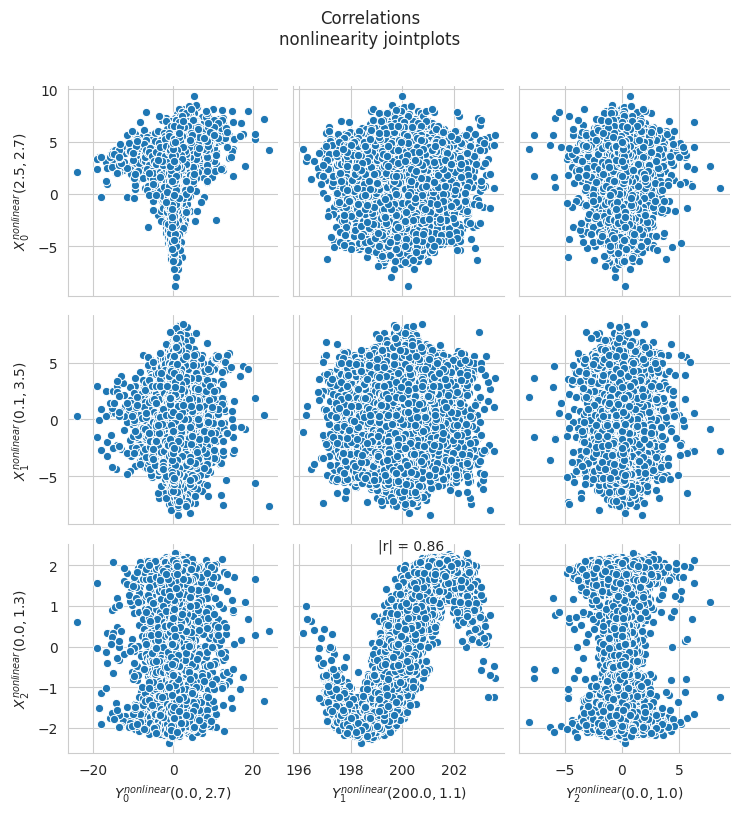

In [1512]:
# draw_correlations(X_non_linear, Y_non_linear, True, labels=['X^{nonlinear}', 'Y^{nonlinear}'], title='nonlinearity_joint_exp_arctan')
compare_variables([('X^{nonlinear}', X_non_linear)], [('Y^{nonlinear}', Y_non_linear)], name='nonlinearity_jointplots', name_init='02')

In [1513]:
thetaX = [0] * d
thetaX[2] = np.pi/2
rot_axis_X = np.array([1, 1, 1])
rotX = Rotation.from_rotvec(thetaX * rot_axis_X)
X = rotX.apply(X_non_linear)
X = X +  0.1 * white_noise(X.shape)

In [1514]:
print(f'X: mean {np.mean(X, axis=0)}, std {np.std(X, axis=0)}')

X: mean [-0.05238694  2.53484211  0.02309894], std [3.47150378 2.73704572 1.32627257]


In [1515]:
thetaY = [0] * d
thetaY[0] = -np.pi / 2
thetaY[1] = -np.pi / 6
rot_axis_Y = np.array([1, 1, 1])
rotY = Rotation.from_rotvec(thetaY * rot_axis_Y)
Y = rotY.apply(Y_non_linear)
Y = Y +  0.1 * white_noise(Y.shape)

In [1516]:
print(f'X: mean {np.mean(Y, axis=0)}, std {np.std(Y, axis=0)}')

X: mean [  65.12319211    4.73498314 -189.0533014 ], std [2.44645862 1.32846116 1.30598467]


$X, Y$ are rotations of a linear combination of $Z + \lambda N1$ and $Z + \lambda N2$ respectively, where $Z, N1, N2$ each drawn from a multivariate gaussian with 0 mean and unit covariance.
$\lambda=0.1$ and the rotations are different and are performed around different axes.

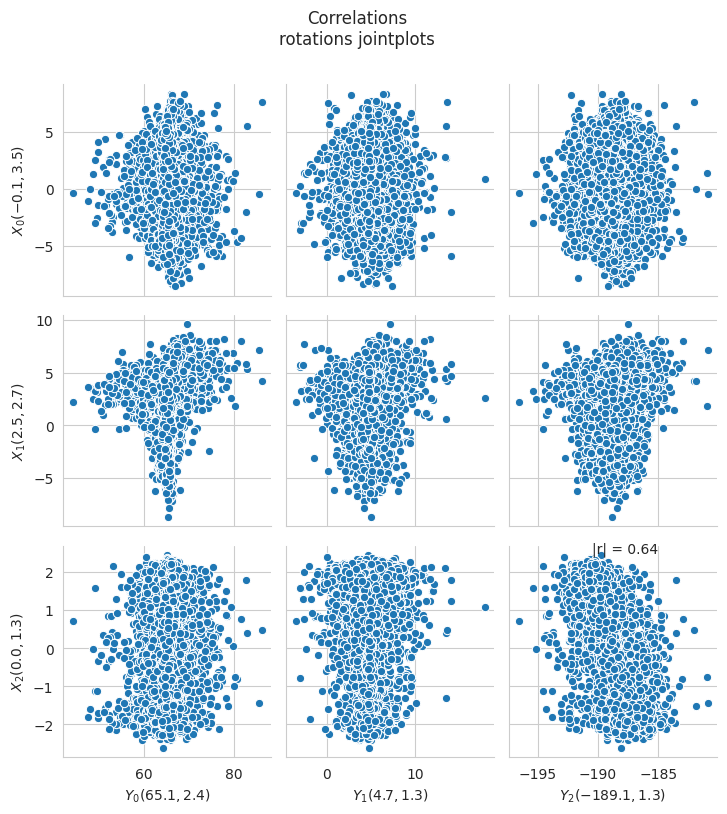

In [1517]:
# draw_correlations(X,Y, True, labels=['X', 'Y'], title='rotation_on_nonlinearities')
compare_variables([('X', X)], [('Y', Y)], name='rotations_jointplots', name_init='03')

### create pytorch model class

notice there is no normalization at the final output. Normalization is performed with apply_transform function

In [1518]:
class Model(nn.Module):
  def __init__(self, hidden_size, input_size, output_size, lr=0.01, activation=None):
      super(Model, self).__init__()
      self.fc1 = nn.Linear(input_size, hidden_size)
      # nn.init.xavier_normal_(self.fc1.weight)
      self.bn1 = nn.BatchNorm1d(num_features=hidden_size)
      self.fc2 = nn.Linear(hidden_size, output_size)
      # nn.init.xavier_normal_(self.fc2.weight)
      self.bn2 = nn.BatchNorm1d(num_features=output_size, )
      self.activation = activation
      
  def forward(self, x):
      u = self.fc1(x)
      u = self.bn1(u)
      if self.activation is not None:
        u = self.activation(u)
      u = self.fc2(u)
      u = self.bn2(u)
      return u
  

In [1519]:
class MlpNet(nn.Module):
    def __init__(self, layer_sizes, input_size, activation=None):
        super(MlpNet, self).__init__()
        if activation is None:
          activation = nn.Identity()
        layers = []
        layer_sizes = [input_size] + layer_sizes
        for l_id in range(len(layer_sizes) - 1):
            if l_id == len(layer_sizes) - 2:
                layers.append(nn.Sequential(
                    nn.BatchNorm1d(num_features=layer_sizes[l_id], affine=False),
                    nn.Linear(layer_sizes[l_id], layer_sizes[l_id + 1]),
                ))
            else:
                layers.append(nn.Sequential(
                    nn.Linear(layer_sizes[l_id], layer_sizes[l_id + 1]),
                    activation(),
                    nn.BatchNorm1d(num_features=layer_sizes[l_id + 1], affine=False),
                ))
        
        self.layers = nn.ModuleList(layers)
        # self.learning_rate = lr
        # self._criterion = nn.MSELoss()
        # self._optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


In [1520]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y.detach(), yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

In [1521]:
def make_eval_step(model, loss_fn):
    # Builds function that performs a step in the train loop
    def eval_step(x, y):
        # Sets model to TRAIN mode
        model.eval()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return eval_step

### train and eval functions

In [1522]:
def find_orthogonal(M, vec):
  # M an orthogonal matrix, vec the starting vector to be orthogonalized wrt M
  # using (modified?) gram schmidt while assuming M is already orthogonal
  def projection(u, v):
      return ((v * u).sum() / (u * u).sum()) * u
  vec -= torch.sum(torch.cat([projection(M[i, :], vec) for i in range(M.shape[0])], dim=1))
  return vec 

In [1523]:
def apply_initial_guess(inp, method='model', **kwargs):
  if method == 'model':
    return inp
  if method == 'independent':
    pass
  if method == 'mean':
    return (inp.mean() * torch.ones([inp.shape[0], 1])).detach()
  if method == 'zero':
    return torch.zeros([inp.shape[0], 1])
  
  raise NotImplementedError(f'initialization method {method} not implemented')

In [1524]:
def apply_transform(model, inp, first=False, **kwargs):
  model.eval()
  out = model(inp)
  if first:
    out = apply_initial_guess(out, model=model, **kwargs)
  out -= out.mean(axis=0)
  std = out.std(axis=0)
  if not first:
    out = torch.div(out, out.std(axis=0))
  return out

In [1525]:
def learn(loader, _x_model, _y_model, _x_train_step, _y_train_step, _max_samples=np.inf, first=False, **kwargs):
  U = []
  V = []
  losses_x = []
  losses_y = []

  sample_count = 0
  inner_loop_steps = kwargs.get('inner_loop_steps', 1)
  

  for i, (x_batch, y_batch) in enumerate(loader):
    sample_count += len(x_batch)
    # if sample_count > _max_samples:
    #   break
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    
    transformed_y_batch = apply_transform(_y_model, y_batch, first)
    for _ in range(inner_loop_steps):
      loss_x = _x_train_step(x_batch, transformed_y_batch)
    losses_x.append(loss_x)

    transformed_x_batch = apply_transform(_x_model, x_batch)
    for _ in range(inner_loop_steps):
      loss_y = _y_train_step(y_batch, transformed_x_batch)
    losses_y.append(loss_y)

    U.append(apply_transform(_y_model, y_batch))
    V.append(transformed_y_batch)

    if first:
      first = False
  U = torch.cat(U).cpu()
  V = torch.cat(V).cpu()
  corr = np.corrcoef(U.detach().numpy(), V.detach().numpy(), rowvar=False)[0, 1]

  return corr, np.mean(losses_x), np.mean(losses_y)


In [1526]:
def evaluate(loader, _x_model, _y_model, _x_eval_step, _y_eval_step, first=False):
  X = []
  Y = []
  U = []
  V = []
  val_loss_x = []
  val_loss_y = []
  with torch.no_grad(): 
    for x_val, y_val in loader:
      x_val = x_val.to(device)
      y_val = y_val.to(device)

      transformed_y_batch = apply_transform(_y_model, y_val, first)
      transformed_x_batch = apply_transform(_x_model, x_val, first)

      X.append(x_val)
      Y.append(y_val)
      U.append(transformed_x_batch)
      V.append(transformed_y_batch)

      val_loss_x.append(_x_eval_step(x_val, transformed_y_batch))
      val_loss_y.append(_y_eval_step(y_val, transformed_x_batch))
  X = torch.cat(X).cpu()
  Y = torch.cat(Y).cpu()
  U = torch.cat(U).cpu()
  V = torch.cat(V).cpu()
  corr = np.corrcoef(U, V, rowvar=False)[0, 1]
  return corr, (X, Y, U, V), np.mean(val_loss_x), np.mean(val_loss_y)


In [1527]:
def build_models(cls, *args, **kwargs):
  model1 = cls(*args)
  model2 = cls(*args)

  model1 = model1.to(device)
  model2 = model2.to(device)

  model1_criterion = nn.MSELoss()
  model1_opt = torch.optim.Adam(model1.parameters(), lr=kwargs.get('learning_rate', 0.01))

  model2_criterion = nn.MSELoss()
  model2_opt = torch.optim.Adam(model2.parameters(), lr=kwargs.get('learning_rate', 0.01))

  train_step1 = make_train_step(model1, model1_criterion, model1_opt)
  train_step2 = make_train_step(model2, model2_criterion, model2_opt)

  eval_step1 = make_eval_step(model1, model1_criterion)
  eval_step2 = make_eval_step(model2, model2_criterion)
  return model1, model2, train_step1, train_step2, eval_step1, eval_step2


### create data split

In [1528]:
x_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(Y).float()
z_tensor = torch.from_numpy(Z).float()

In [1529]:
from sklearn.model_selection import train_test_split

In [1530]:
X_train, X_test, Y_train, Y_test, Z_train, Z_test, _, x_p_test, _, y_p_test = train_test_split(x_tensor, y_tensor, Z, X_prior, Y_prior, test_size=0.5, random_state=42, shuffle=True)

In [1531]:
muX, stdX = get_normalization_params(X_train)
muY, stdY = get_normalization_params(Y_train)
muZ, stdZ = get_normalization_params(Z_train)

In [1532]:
X_train = normalize(X_train, muX, stdX)
X_test = normalize(X_test, muX, stdX)
Y_train = normalize(Y_train, muY, stdY)
Y_test = normalize(Y_test, muY, stdY)
Z_train = normalize(Z_train, muZ, stdZ)
Z_test = normalize(Z_test, muZ, stdZ)

In [1533]:
cca = CCA(n_components=1)
X_train_c, Y_train_c = cca.fit_transform(X_train, Y_train)
X_c, Y_c = cca.transform(X_test, Y_test)
CCAtest = get_max_corr(X_c, Y_c)
print(CCAtest)

0.8444629389724377


In [1534]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.5, random_state=42, shuffle=True)

In [1535]:
train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)

In [1536]:
len(train_dataset)

2500

In [1537]:
# train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

### Run

In [1538]:
max_samples = len(train_dataset) // 1

In [1539]:
max_samples

2500

In [1540]:
wanted_dim = 1

In [1541]:
hidden_size = 32
num_hidden_layers = 3
max_epochs = 30
lr = 0.01
act = None
act = nn.ReLU
batch_size = 32 * 2

In [1542]:
print(batch_size)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=min(len(val_dataset), 500))

64


In [1543]:
torch.manual_seed(0)
layer_sizes = [hidden_size]*num_hidden_layers + [wanted_dim]
x_model, y_model, x_train_step, y_train_step, x_eval_step, y_eval_step = \
  build_models(MlpNet, layer_sizes, X.shape[-1], act, learning_rate=lr)

In [1544]:
first = True

U_init = x_model(X_test).detach().numpy()
V_init = y_model(Y_test).detach().numpy()
last_score, _ , val_x_loss, val_y_loss = evaluate(val_loader, x_model, y_model, x_eval_step, y_eval_step, first=first)
print(last_score)
training_first_score, (_, _, Us, Vs) , train_x_loss, train_y_loss = evaluate(train_loader, x_model, y_model, x_eval_step, y_eval_step, first=first)

-0.036820511097551835


In [1545]:
s = f'epoch: {-1}\tscore(correlation) {last_score:.3}\tX model loss {val_x_loss:.3}\tY model loss {val_y_loss:.3}'
print(s)

epoch: -1	score(correlation) -0.0368	X model loss 0.00279	Y model loss 0.0126


In [1546]:
scores = defaultdict(list)
losses = defaultdict(list)
mean_statistics = defaultdict(list)
std_statistics = defaultdict(list)

In [1547]:
log_scores_before_learning = True

if log_scores_before_learning:
  scores['Ours'].append(last_score)
  # scores['training'].append(training_first_score)
  scores['epoch'].append(-1)

  mean_statistics['U_mean'] = Us.mean().item()
  mean_statistics['V_mean'] = Vs.mean().item()
  std_statistics['U_std'] = Us.std().item()
  std_statistics['V_std'] = Vs.std().item()
  mean_statistics['epoch'].append(-1)
  std_statistics['epoch'].append(-1)

  losses['x_model_validation'].append(val_x_loss)
  losses['y_model_validation'].append(val_y_loss)
  losses['x_model_training'].append(train_x_loss)
  losses['y_model_training'].append(train_y_loss)
  losses['epoch'].append(-1)

In [1548]:
max_score = -np.inf

for epoch in range(max_epochs):
  # train
  train_score, train_x_loss, train_y_loss = learn(train_loader, x_model, y_model, x_train_step, y_train_step, _max_samples=max_samples, first=first)
  if first:
    first = False
  # validate
  current_score, (Xs, Ys, Us, Vs), val_x_loss, val_y_loss = evaluate(val_loader, x_model, y_model, x_eval_step, y_eval_step)

  # log
  # scores['training'].append(train_score)
  losses['x_model_training'].append(train_x_loss)
  losses['y_model_training'].append(train_y_loss)
  losses['x_model_validation'].append(val_x_loss)
  losses['y_model_validation'].append(val_y_loss)
  
  mean_statistics['U_mean'] = Us.mean().item()
  # print(Us.mean().item())
  mean_statistics['V_mean'] = Vs.mean().item()
  std_statistics['U_std'] = Us.std().item()
  std_statistics['V_std'] = Vs.std().item()

  scores['Ours'].append(current_score)
  
  scores['epoch'].append(epoch)
  losses['epoch'].append(epoch)
  mean_statistics['epoch'].append(epoch)
  std_statistics['epoch'].append(epoch)

  print(f'epoch: {epoch}\tscore(correlation) {last_score:.3}\tX model loss {val_x_loss:.3}\tY model loss {val_y_loss:.3}')
  
  if current_score > max_score:
    max_score = current_score
    torch.save(x_model, 'x_model_best.pth')
    torch.save(y_model, 'y_model_best.pth')
  last_score = current_score

epoch: 0	score(correlation) -0.0368	X model loss 0.239	Y model loss 0.259
epoch: 1	score(correlation) 0.877	X model loss 0.231	Y model loss 0.247
epoch: 2	score(correlation) 0.878	X model loss 0.229	Y model loss 0.245
epoch: 3	score(correlation) 0.881	X model loss 0.225	Y model loss 0.242
epoch: 4	score(correlation) 0.882	X model loss 0.23	Y model loss 0.24
epoch: 5	score(correlation) 0.883	X model loss 0.226	Y model loss 0.24
epoch: 6	score(correlation) 0.885	X model loss 0.226	Y model loss 0.239
epoch: 7	score(correlation) 0.884	X model loss 0.228	Y model loss 0.24
epoch: 8	score(correlation) 0.883	X model loss 0.225	Y model loss 0.234
epoch: 9	score(correlation) 0.885	X model loss 0.222	Y model loss 0.236
epoch: 10	score(correlation) 0.887	X model loss 0.225	Y model loss 0.235
epoch: 11	score(correlation) 0.886	X model loss 0.223	Y model loss 0.232
epoch: 12	score(correlation) 0.889	X model loss 0.216	Y model loss 0.227
epoch: 13	score(correlation) 0.892	X model loss 0.22	Y model lo

In [1549]:
x_model.eval()
y_model.eval()
print()

In [1550]:
x_model_best = torch.load('x_model_best.pth')
x_model_best.eval()

y_model_best = torch.load('y_model_best.pth')
y_model_best.eval()

print()

In [1551]:
# re-evaluate
U_best = x_model_best(X_test).detach().numpy()
V_best = y_model_best(Y_test).detach().numpy()

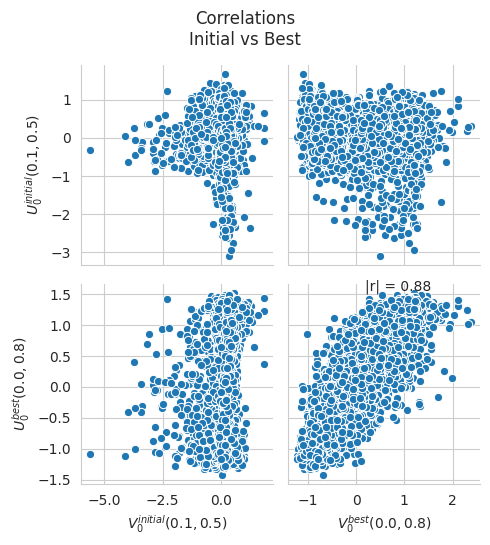

In [1552]:
compare_variables([('U^{initial}', U_init), ('U^{best}', U_best)], [('V^{initial}', V_init), ('V^{best}', V_best)], name='Initial_vs_Best', name_init='04')

Find linear CCA result for wanted dim

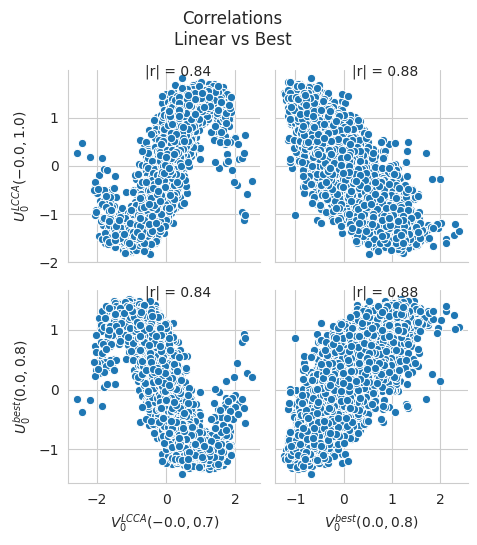

In [1553]:
compare_variables([('U^{LCCA}', X_c), ('U^{best}', U_best)], [('V^{LCCA}', Y_c), ('V^{best}', V_best)], name='Linear_vs_Best', name_init='05')

In [1554]:
scores['LinearCCA'] = [get_max_corr(X_c, Y_c)] * len(scores['epoch'])
scores['Maximum score'] = [get_max_corr(X_prior, Y_prior)] * len(scores['epoch'])

In [1555]:
mean_statistics_data = pd.DataFrame(mean_statistics)
df_mean_statistics = pd.melt(mean_statistics_data, 'epoch')
std_statistics_data = pd.DataFrame(std_statistics)
df_std_statistics = pd.melt(std_statistics_data, 'epoch')

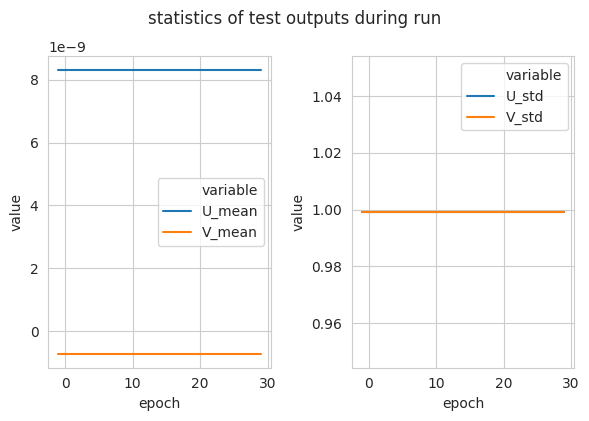

In [1556]:
f, (ax0, ax1) = plt.subplots(1, 2)
sns.lineplot('epoch', 'value', 'variable', data=df_mean_statistics, ax=ax0)
sns.lineplot('epoch', 'value', 'variable', data=df_std_statistics, ax=ax1)
ax0.ticklabel_format(useOffset=False)
ax1.ticklabel_format(useOffset=False)
f.suptitle('statistics of test outputs during run', y=1.04)
plt.tight_layout()
plt.savefig(path_to_save + '07' + 'test_statistics.png')

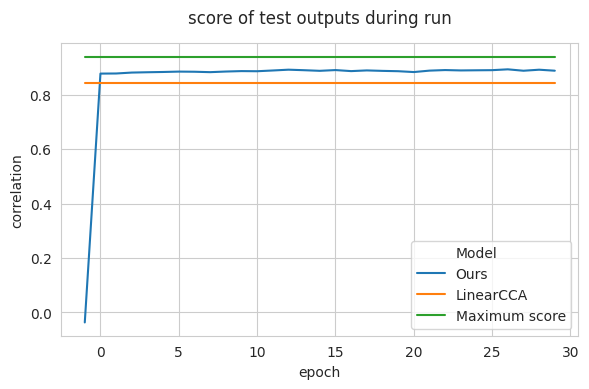

In [1557]:
scores_data = pd.DataFrame(scores)
# df_scores = pd.melt(scores_data[scores_data.epoch != -1], 'epoch', var_name='Model', value_name='correlation')
df_scores = pd.melt(scores_data, 'epoch', var_name='Model', value_name='correlation')
g = sns.lineplot('epoch', 'correlation', 'Model', data=df_scores)
g.set_title('score of test outputs during run', y=1.04)
plt.tight_layout()
plt.savefig(path_to_save + '08' + 'test_scores.png')

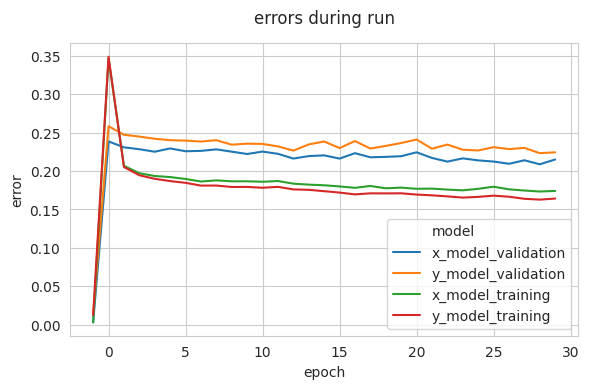

In [1558]:
losses_data = pd.DataFrame(losses)
# df_losses = pd.melt(losses_data[losses_data.epoch != -1], 'epoch', var_name='model', value_name='error')
df_losses = pd.melt(losses_data, 'epoch', var_name='model', value_name='error')
g = sns.lineplot('epoch', 'error', 'model', data=df_losses)
g.set_title('errors during run', y=1.04)
plt.tight_layout()
plt.savefig(path_to_save + '09' + 'errors.png')

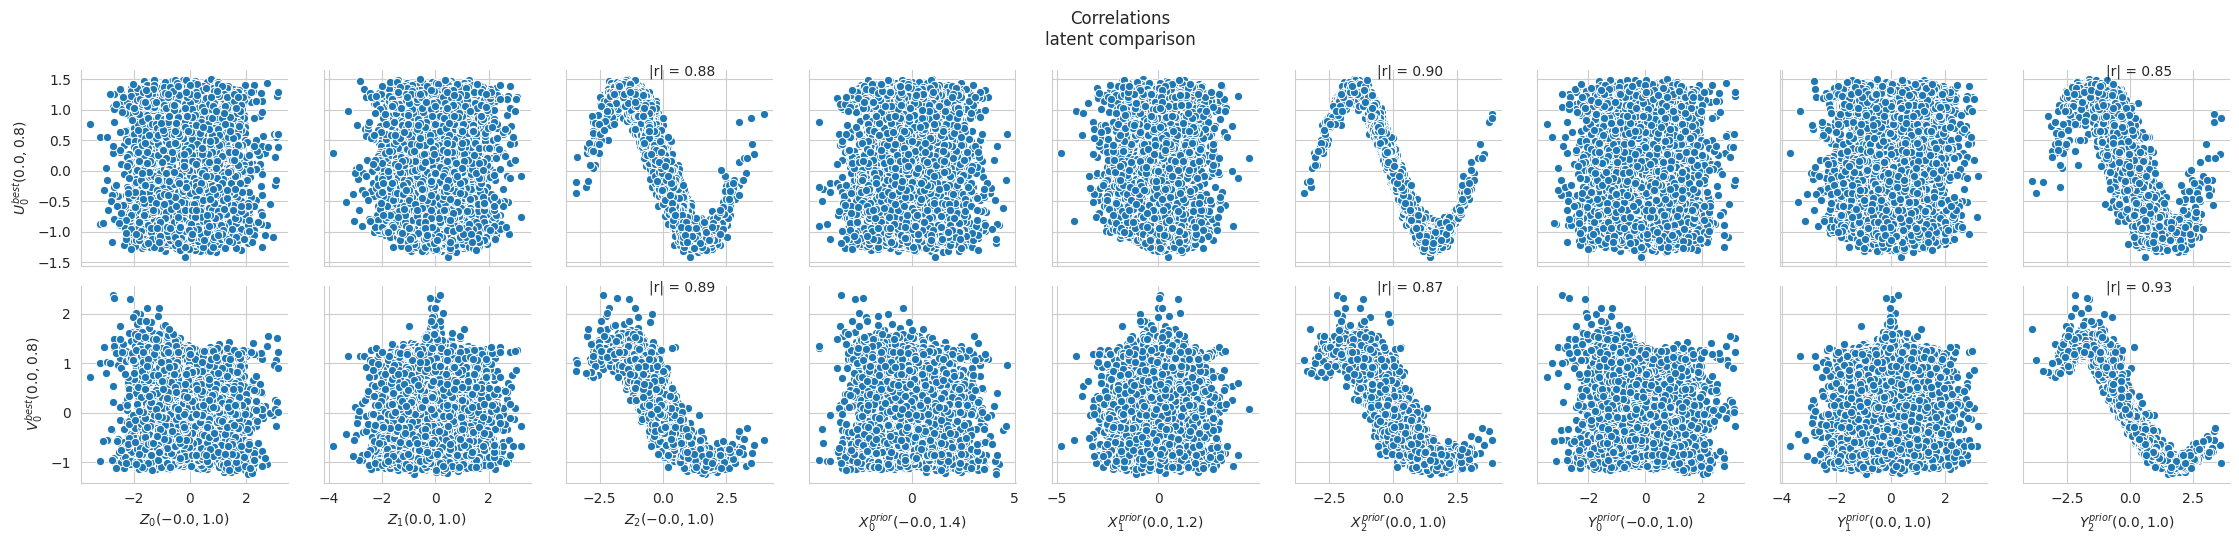

In [1559]:
compare_variables([('U^{best}', U_best), ('V^{best}', V_best)], [('Z', Z_test), ('X^{prior}', x_p_test), ('Y^{prior}', y_p_test)], 'latent comparison', name_init='06')
# compare_variables([('U^{best}', U_best), ('V^{best}', V_best)], [('Z', Z_test)], 'latent comparison', name_init='06')